In [1]:
import cv2
import os
import numpy as np
import time
from matplotlib import pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = [30, 15]

In [3]:
detect_on_tiles = 'y'
tiles_x = 2
tiles_y = 3
video_file = '/home/vgoncalves/personal-git/people_detection_compare/resources/virat_dataset/VIRAT_S_010000_00_000000_000165.mp4'
output_video = 'n'
confidence = 0.2

In [4]:
video_file_name = os.path.splitext(os.path.split(video_file)[1])[0]

In [5]:
main_dir = os.path.abspath(os.path.dirname(os.path.abspath(os.getcwd())))

In [6]:
main_dir

'/home/vgoncalves/personal-git/people-detection-compare'

In [32]:
mobile_ssd_dir = os.path.join(main_dir, 'models/mobile_ssd')
prototxt = os.path.join(mobile_ssd_dir, 'MobileNetSSD_deploy.prototxt.txt')
model = os.path.join(mobile_ssd_dir, 'MobileNetSSD_deploy.caffemodel')

In [33]:
classes_path = os.path.sep.join([mobile_ssd_dir, "classes"])
MOBILE_SSD_CLASSES = open(classes_path).read().strip().split("\n")

In [34]:
mobile_ssd_net = cv2.dnn.readNetFromCaffe(prototxt, model)

In [76]:
def tiles_info(image, tiles_x, tiles_y, margin_percent):
    tiles_dict = {}
    rect_dimension_x = image.shape[0] / tiles_x
    rect_dimension_y = image.shape[1] / tiles_y

    for tile_x in range(0, tiles_x):
        for tile_y in range(0, tiles_y):
            x = int(tile_x * rect_dimension_x)
            y = int(tile_y * rect_dimension_y)
            final_x = int(x + rect_dimension_x)
            final_y = int(y + rect_dimension_y)


            margin_x = int(rect_dimension_x * margin_percent)
            margin_y = int(rect_dimension_y * margin_percent)

            new_x = max(0, x - margin_x)
            new_y = max(0, y - margin_y)
            new_final_x = min(image.shape[0], final_x + margin_x)
            new_final_y = min(image.shape[1], final_y + margin_y)

            margin_left = x - new_x
            margin_top = y - new_y
            margin_right = new_final_x - final_x
            margin_bottom = new_final_y - final_y

            tiles_dict[(tile_x, tile_y)] = {
                'coords': (x, y, final_x, final_y),
                'new_coords': (new_x, new_y, new_final_x, new_final_y),
                'margins_length': (margin_left, margin_top, margin_right, margin_bottom)}
    return tiles_dict


def tile_image(image, tiles_x, tiles_y, tiles_dict):

    tiles = np.zeros((tiles_x, tiles_y), object)

    for tile_x in range(0, tiles_x):
        for tile_y in range(0, tiles_y):
            (x, y, final_x, final_y) = tiles_dict[tile_x, tile_y]['new_coords']
            tile = image[x:final_x, y:final_y]
            tiles[tile_x, tile_y] = tile

    return tiles

In [47]:
tiles_dict = None

if detect_on_tiles == 'y':
    
    # Get frame to define the tiles size
    vs = cv2.VideoCapture(video_file)
    success, frame = vs.read()
    tiles_dict = tiles_info(frame, tiles_x, tiles_y, 0.25)

In [77]:
tiles_dict

{(0, 0): {'coords': (0, 0, 360, 426),
  'margins_length': (0, 0, 90, 106),
  'new_coords': (0, 0, 450, 532)},
 (0, 1): {'coords': (0, 426, 360, 852),
  'margins_length': (0, 106, 90, 106),
  'new_coords': (0, 320, 450, 958)},
 (0, 2): {'coords': (0, 853, 360, 1279),
  'margins_length': (0, 106, 90, 1),
  'new_coords': (0, 747, 450, 1280)},
 (1, 0): {'coords': (360, 0, 720, 426),
  'margins_length': (90, 0, 0, 106),
  'new_coords': (270, 0, 720, 532)},
 (1, 1): {'coords': (360, 426, 720, 852),
  'margins_length': (90, 106, 0, 106),
  'new_coords': (270, 320, 720, 958)},
 (1, 2): {'coords': (360, 853, 720, 1279),
  'margins_length': (90, 106, 0, 1),
  'new_coords': (270, 747, 720, 1280)}}

In [30]:
def detect_single_frame(model, frame, confidence=0.2, tile_info=None):
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 0.007843, (300, 300), 127.5)

    # pass the blob through the network and obtain the detections and
    # predictions
    model.setInput(blob)

    start_time = time.time()
    detections = model.forward()
    total_time = time.time() - start_time

    boxes = []
    frame_with_boxes = frame.copy()

    # loop over the detections
    for i in np.arange(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with the
        # prediction
        _confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the `confidence` is
        # greater than the minimum confidence
        if _confidence > confidence:
            # extract the index of the class label from the `detections`,
            # then compute the (x, y)-coordinates of the bounding box for
            # the object
            idx = int(detections[0, 0, i, 1])
            if MOBILE_SSD_CLASSES[idx] == 'person':

                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")

                if tile_info is not None:
                    startX += tile_info['row']*int(tile_info['dim_y'])
                    startY += tile_info['column']*int(tile_info['dim_x'])
                    endX += tile_info['row']*int(tile_info['dim_y'])
                    endY += tile_info['column']*int(tile_info['dim_x'])
                    
                boxes.append([startX, startY, endX, endY])

                label = "{:.2f}%".format(_confidence * 100)
                cv2.rectangle(frame_with_boxes, (startX, startY), (endX, endY), (0,255,0), 2)
                y = startY - 15 if startY - 15 > 15 else startY + 15
                cv2.putText(frame_with_boxes, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

    return boxes, total_time, frame_with_boxes


In [53]:
vs = cv2.VideoCapture(video_file)

In [92]:
##read from specific frame
vs.set(cv2.CAP_PROP_POS_FRAMES,560)

True

In [93]:
success, frame = vs.read()

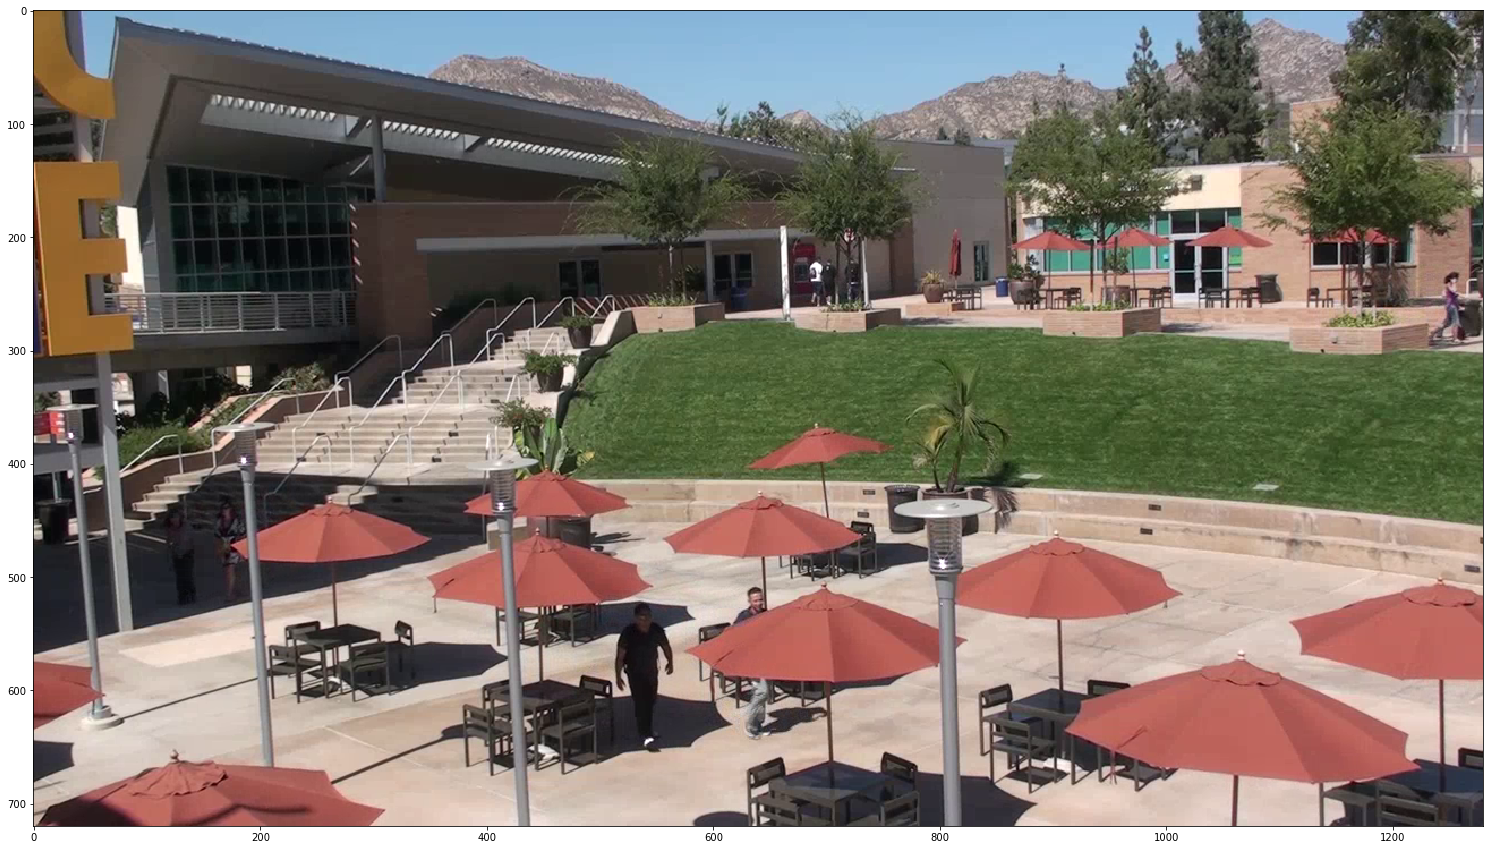

In [94]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()

In [95]:
frame.shape

(720, 1280, 3)

In [96]:
rect_dimension_x = frame.shape[0] / tiles_x
rect_dimension_y = frame.shape[1] / tiles_y

In [97]:
rect_dimension_x

360.0

In [98]:
rect_dimension_y

426.6666666666667

In [99]:
tiles = tile_image(frame, tiles_x, tiles_y, tiles_dict)

In [100]:
tiles[1,1].shape

(450, 638, 3)

In [101]:
tiles_dict

{(0, 0): {'coords': (0, 0, 360, 426),
  'margins_length': (0, 0, 90, 106),
  'new_coords': (0, 0, 450, 532)},
 (0, 1): {'coords': (0, 426, 360, 852),
  'margins_length': (0, 106, 90, 106),
  'new_coords': (0, 320, 450, 958)},
 (0, 2): {'coords': (0, 853, 360, 1279),
  'margins_length': (0, 106, 90, 1),
  'new_coords': (0, 747, 450, 1280)},
 (1, 0): {'coords': (360, 0, 720, 426),
  'margins_length': (90, 0, 0, 106),
  'new_coords': (270, 0, 720, 532)},
 (1, 1): {'coords': (360, 426, 720, 852),
  'margins_length': (90, 106, 0, 106),
  'new_coords': (270, 320, 720, 958)},
 (1, 2): {'coords': (360, 853, 720, 1279),
  'margins_length': (90, 106, 0, 1),
  'new_coords': (270, 747, 720, 1280)}}

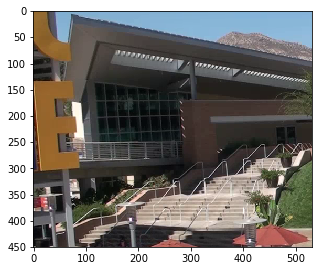

(450, 532, 3)


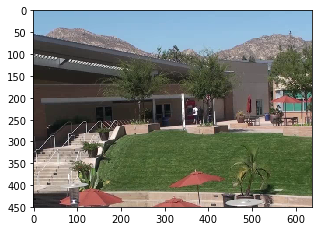

(450, 638, 3)


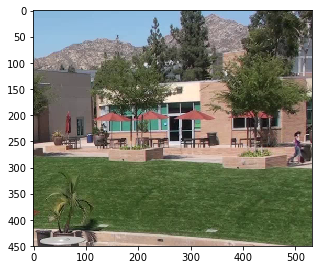

(450, 533, 3)


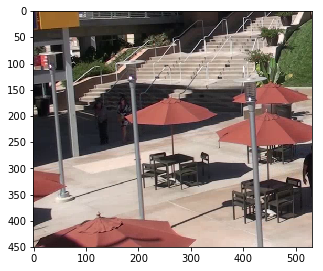

(450, 532, 3)


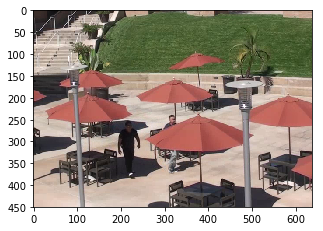

(450, 638, 3)


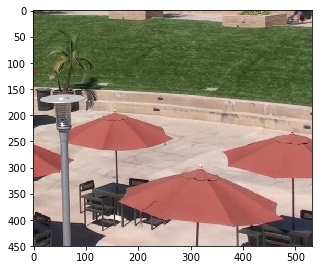

(450, 533, 3)


In [102]:
plt.rcParams['figure.figsize'] = [5, 5]
for row in range(0, tiles_x):
    for column in range(0, tiles_y):
        plt.imshow(cv2.cvtColor(tiles[row,column], cv2.COLOR_BGR2RGB))
        plt.show()
        print(tiles[row,column].shape)
plt.rcParams['figure.figsize'] = [30, 15]

In [103]:
new_x, new_y, new_final_x, new_final_y = tiles_dict[0,0]['new_coords']

In [104]:
new_final_x

450

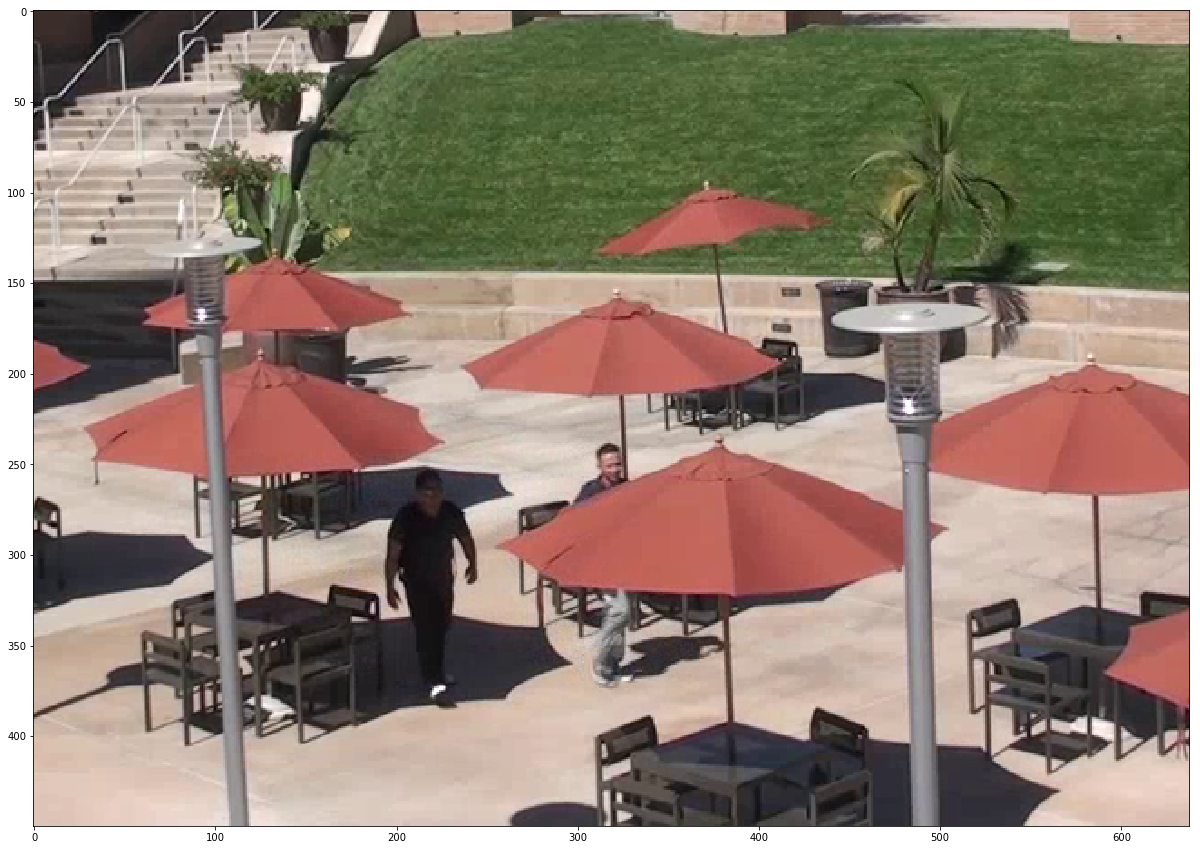

In [105]:
plt.imshow(cv2.cvtColor(tiles[1,1], cv2.COLOR_BGR2RGB))
plt.show()

In [106]:
tiles[1, 1].shape

(450, 638, 3)

In [110]:
boxes, total_time, new_tile_draw = detect_single_frame(mobile_ssd_net, tiles[1, 1])


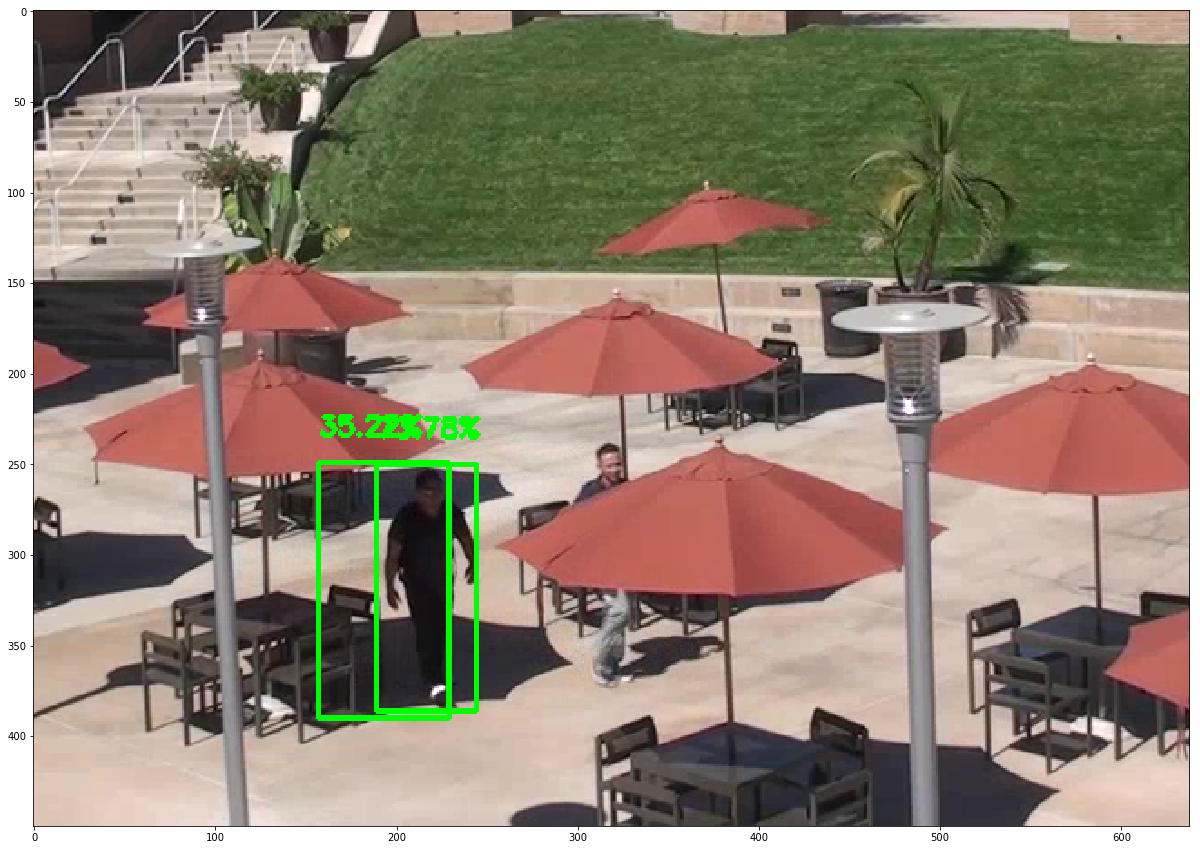

In [111]:
plt.imshow(cv2.cvtColor(new_tile_draw, cv2.COLOR_BGR2RGB))
plt.show()

In [107]:
# boxes, total_time, new_tile_draw = detect_single_frame(mobile_ssd_net, tiles[1, 1], tile_info={'dim_x': 360, 
#                                                                                               'dim_y': 426,
#                                                                                               'row':1,
#                                                                                               'column':1})

In [112]:
boxes

[[189, 250, 244, 386], [157, 249, 229, 390]]

In [113]:
adjusted_boxes = []
row = 1
column = 1

for box in boxes:
    (startX, startY, endX, endY) = box
    startX += row*int(rect_dimension_y)
    startY += column*int(rect_dimension_x)
    endX += row*int(rect_dimension_y)
    endY += column*int(rect_dimension_x)
    
    print(row, column)
    print(row*int(rect_dimension_y))
    print(column*int(rect_dimension_x))
    #adjusted_boxes.append([startX, startY, endX, endY])
    #adjusted_boxes.append([startX, startY, endX, endY])

1 1
426
360
1 1
426
360


In [115]:
def box_new_coords(box, row, column, tiles_dict):
    (startX, startY, endX, endY) = box

    new_x, new_y, new_final_x, new_final_y = tiles_dict[row,column]['new_coords']

    startX += new_y
    startY += new_x
    endX += new_y
    endY += new_x
    

    return startX, startY, endX, endY

In [116]:
original_frame = frame.copy()
for box in boxes:
    #(startX, startY, endX, endY) = box
    
    startX, startY, endX, endY = box_new_coords(box, 1, 1, tiles_dict)
    cv2.rectangle(original_frame, (startX, startY), (endX, endY), (0,255,0), 2)

320
270
320
270


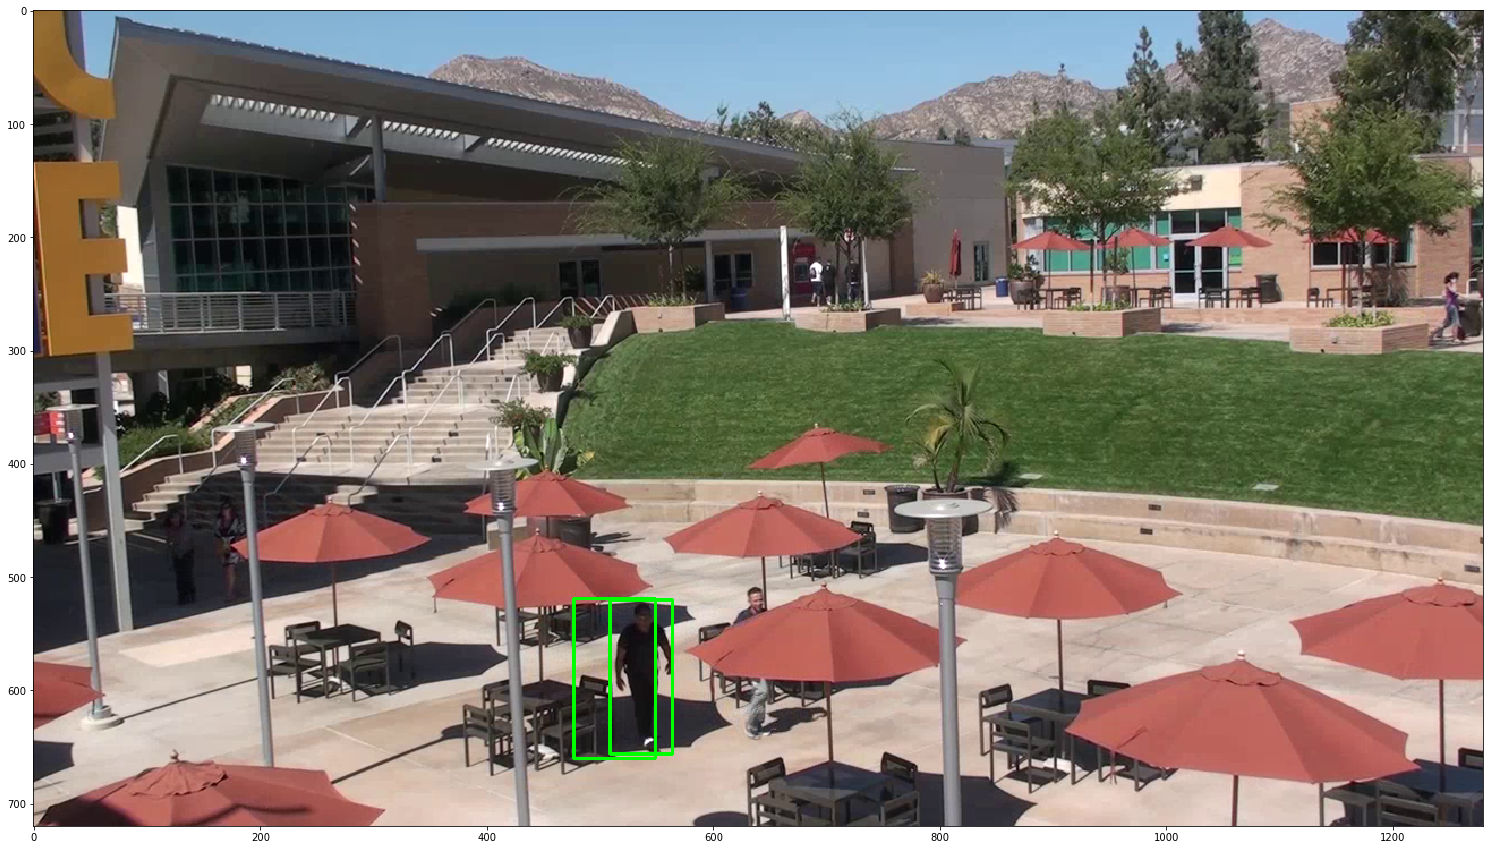

In [117]:
plt.imshow(cv2.cvtColor(original_frame, cv2.COLOR_BGR2RGB))
plt.show()